In [11]:
# Make thioformaldehyde (H2CS) cubes for inspection with DS9
from astroquery.splatalogue import Splatalogue
from spectral_cube import SpectralCube
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as nd

### Use Splatalogue to query H2CS lines in Bands 3 and 4, then Band 6 (observed)

In [7]:
tbl = Splatalogue.query_lines(85*u.GHz, 155*u.GHz, chemical_name=' H2CS ', line_lists=['JPL'],
                              energy_max=150, energy_type='eu_k', show_qn_code=True)
tbl.show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Quantum Number Code,Linelist
0,H2CS,Thioformaldehyde,--,--,101.47762,0.00012,"3(1,3)-2(1,2)",-3.6341,21.69902,7.98,-4.90073,0.49,12.5521,18.05957,15.93703,22.9297,303,JPL
1,H2CS,Thioformaldehyde,--,--,103.03999,0.0001,"3(2,2)-2(2,1)",-4.3594,4.52097,1.663,-5.08492,0.2,40.0668,57.64686,43.50384,62.59197,303,JPL
2,H2CS,Thioformaldehyde,--,--,103.04022,0.00015,"3(0,3)-2(0,2)",-4.0278,8.13836,2.993,-4.82961,0.2,3.4374,4.94562,6.87445,9.89075,303,JPL
3,H2CS,Thioformaldehyde,--,--,103.05181,0.00028,"3(2,1)-2(2,0)",-4.3593,4.52098,1.663,-5.08476,0.13,40.0669,57.647,43.50434,62.59268,303,JPL
4,H2CS,Thioformaldehyde,--,--,104.61704,7e-05,"3(1,2)-2(1,1)",-3.6079,21.70215,7.981,-4.86098,0.77,12.6568,18.21021,16.14645,23.231,303,JPL
5,H2CS,Thioformaldehyde,--,--,135.297811,0.00025,"4(1,4)-3(1,3)",-3.2444,30.5155,11.222,-4.48704,0.64,15.937,22.92966,20.45005,29.42289,303,JPL
6,H2CS,Thioformaldehyde,--,--,137.36917,0.00025,"4(3,2)-3(3,1)",-3.7147,14.24214,5.238,-4.79819,b,89.1451,128.25918,93.72724,134.85182,303,JPL
7,H2CS,Thioformaldehyde,--,--,137.36917,0.00025,"4(3,2)-3(3,1)",-3.7147,14.24214,5.238,-4.79819,b,89.1451,128.25918,93.72724,134.85182,303,JPL
8,H2CS,Thioformaldehyde,--,--,137.371051,0.0003,"4(0,4)-3(0,3)",-3.6615,10.84945,3.99,-4.43922,0.37,6.8745,9.89082,11.45671,16.48355,303,JPL
9,H2CS,Thioformaldehyde,--,--,137.382029,0.00032,"4(2,3)-3(2,2)",-3.8626,8.13826,2.993,-4.56399,0.10,43.5038,62.5919,48.08637,69.18516,303,JPL


In [8]:
tbl = Splatalogue.query_lines(239.9*u.GHz, 275*u.GHz, chemical_name=' H2CS ', line_lists=['JPL'], 
                              energy_max=150, energy_type='eu_k', show_qn_code=True)
tbl.show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Quantum Number Code,Linelist
0,H2CS,Thioformaldehyde,--,--,240.26632,0.0004,"7(0,7)-6(0,6)",-2.9722,18.98681,6.982,-3.68963,0.55,24.0546,34.609,32.06902,46.1399,303,JPL
1,H2CS,Thioformaldehyde,--,--,240.38175,0.00034,"7(2,6)-6(2,5)",-3.085,17.4397,6.414,-3.72591,0.16,60.6875,87.31527,68.70577,98.85171,303,JPL
2,H2CS,Thioformaldehyde,240.5482286,0.0001704,--,--,"7(2,5)-6(2,4)",-3.0845,17.43644,6.412,-3.72509,0.16,60.6945,87.32534,68.71833,98.86977,303,JPL
3,H2CS,Thioformaldehyde,--,--,244.04784,0.00059,"7(1,6)-6(1,5)",-2.5104,55.8065,20.523,-3.67817,0.91,33.5928,48.33227,41.73336,60.04465,303,JPL
4,H2CS,Thioformaldehyde,270.5207397,0.0003169,--,--,"8(1,8)-7(1,7)",-2.3767,64.08661,23.568,-3.53827,--,40.7563,58.63889,49.7799,71.62176,303,JPL
5,H2CS,Thioformaldehyde,274.5208698,0.0003318,--,--,"8(0,8)-7(0,7)",-2.8163,21.70009,7.98,-3.51233,--,32.069,46.13987,41.22603,59.31472,303,JPL
6,H2CS,Thioformaldehyde,274.7020548,0.0002753,--,--,"8(2,7)-7(2,6)",-2.9201,20.34243,7.481,-3.53953,--,68.7058,98.85175,77.86887,112.0353,303,JPL
7,H2CS,Thioformaldehyde,274.952473,0.0002755,--,--,"8(2,6)-7(2,5)",-2.9193,20.34446,7.482,-3.5383,--,68.7183,98.86974,77.88973,112.0653,303,JPL


### Extract cubes from around each of the lines we detect in mean spectra

In [5]:
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '137_spw69'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
h2cscube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=137.371051*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
h2cscube.write('H2CS_404-303.fits')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


OSError: File 'H2CS_404-303.fits' already exists.

In [ ]:
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '102_spw29'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
h2cscube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=103.04022*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
h2cscube.write('H2CS_303-202.fits')

In [ ]:
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '102_spw23'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
h2cscube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=101.47762*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
h2cscube.write('H2CS_313-212.fits')

In [ ]:
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '103_spw31'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
h2cscube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=104.61704*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
h2cscube.write('H2CS_312-211.fits')

In [ ]:
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '135_spw47'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
h2cscube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=135.297811*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
h2cscube.write('H2CS_414-313.fits')

In [ ]:
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '139_spw71'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
h2cscube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=139.48341*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
h2cscube.write('H2CS_413-312.fits')

### Make moment maps out of each of these subcubes

In [25]:
def get_noise_map(cube_noise):
    cube_sclip = cube_noise.sigma_clip_spectrally(3) # Clip values above 3-sigma 
    mad_std_spectrum_sclip = cube_sclip.mad_std(axis=(1, 2))
    plt.plot(mad_std_spectrum_sclip.spectral_axis.value, mad_std_spectrum_sclip.value, 
             drawstyle='steps-mid')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel(r' Noise standard deviation $\sigma$ (K)')
    plt.ylim([0., 0.30]) # Best to extend the range to 0.
    plt.axhline(0.25, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
    plt.legend(frameon=True)
    mad_std_map_sclip = cube_sclip.mad_std(axis=0) # Calculate sigma along the spectral dimension
    return mad_std_map_sclip

def get_signal_mask_scipy(cube_signal, mad_std_map_sclip):
    '''Please pass an already-masked cube to cube_signal'''
    # Make a low and high mask
    low_snr_mask = (cube_signal > 3 * mad_std_map_sclip).include()
    high_snr_mask = (cube_signal > 10 * mad_std_map_sclip).include()
    low_snr_mask = low_snr_mask.compute() # We need to convert from a dask array to a numpy array.
    high_snr_mask = high_snr_mask.compute()
    # Find connected structures
    structure = np.ones((3, 3, 3), dtype=bool)
    low_snr_mask_labels, num_labels = nd.label(low_snr_mask, structure=structure)
    print(f"Initial number of regions found: {num_labels}")
    # From the labels, count the number of pixels within each label.
    num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
                                         labels=low_snr_mask_labels,
                                         index=range(1, num_labels + 1)) # +1 offset for mask labels
    # Repeat for the high signal mask.
    num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
                                        labels=low_snr_mask_labels,
                                        index=range(1, num_labels + 1)) # +1 offset for mask labels
    # To preserve the low_snr_mask, we will create a new signal mask where we will remove 
    # regions that do not pass the criteria.
    signal_mask = low_snr_mask
    low_min_pixels = 40
    high_min_pixels = 10
    for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, 
                                                          num_pixels_in_low_snr_mask)):
        if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
            # This region passes the criteria. Keep it in the mask.
            continue
        # Remove regions that do not pass the criteria.
        # NOTE: enumerate will start with 0, but the mask labels start at 1
        # We apply a +1 offset to `num` to account for this.
        signal_mask[low_snr_mask_labels == num + 1] = False
    signal_mask_labels, num_labels = nd.label(signal_mask,
                                              structure=structure)
    print(f"Final number of regions found: {num_labels}")
    signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=1)
    return signal_mask

In [88]:
# Get overall cube
cube = SpectralCube.read('H2CS_414-313.fits', use_dask=True)
cube

DaskVaryingResolutionSpectralCube with shape=(85, 512, 512) and unit=Jy / beam and chunk size (85, 512, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     85  type_s: VRAD      unit_s: km / s  range:      -10.425 km / s:      80.460 km / s

In [89]:
subcube = cube.spectral_slab(-10*u.km/u.s, 40*u.km/u.s)

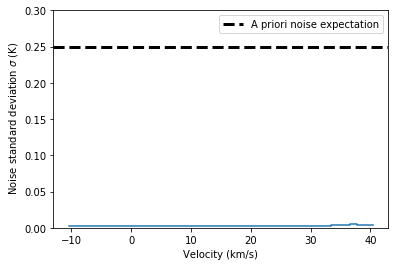

In [90]:
# Get noise map
mad_std_map_sclip = get_noise_map(subcube)

In [91]:
plain_mask = subcube >= 3 * mad_std_map_sclip
plain_masked_slab = subcube.with_mask(plain_mask)

In [92]:
signal_mask = get_signal_mask_scipy(plain_masked_slab, mad_std_map_sclip)
masked_cube = plain_masked_slab.with_mask(signal_mask)

Initial number of regions found: 1111
Final number of regions found: 6


/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


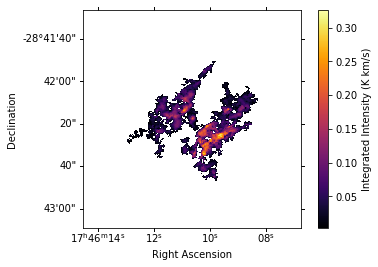

In [93]:
masked_moment0 = masked_cube.moment0() # masked_cubes[n]

ax = plt.subplot(projection=masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')
ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


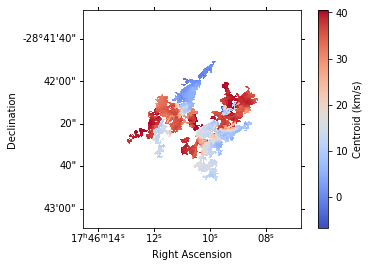

In [94]:
masked_moment1 = masked_cube.moment1() # masked_cubes[n]

ax = plt.subplot(projection=masked_moment1.wcs)
im = ax.imshow(masked_moment1.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Centroid (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

In [25]:
from astroquery.splatalogue import Splatalogue
from astropy import units as u
from spectral_cube import SpectralCube
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
tbl = Splatalogue.query_lines(109*u.GHz, 111*u.GHz, chemical_name=' NH2D ', line_lists=['JPL'],
                              energy_max=150, energy_type='eu_k', show_qn_code=True)
tbl

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Quantum Number Code,Linelist
str4,str7,int64,int64,float64,float64,str23,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,str3
NH2D,Ammonia,--,--,110.1520963,1.5e-05,"1(1,1)0a-1(0,1)0s,F=0-1",-4.6725,1.06115,0.0,-4.78231,--,11.1018,15.97292,14.77608,21.25936,1405,JPL
NH2D,Ammonia,--,--,110.1530165,1.5e-05,"1(1,1)0a-1(0,1)0s,F=2-1",-4.5756,1.32638,0.0,-5.38438,--,11.1018,15.97292,14.77611,21.2594,1405,JPL
NH2D,Ammonia,--,--,110.1535868,1.5e-05,"1(1,1)0a-1(0,1)0s,F=2-2",-4.0985,3.9789,0.0,-4.90728,--,11.1018,15.97292,14.77613,21.25943,1405,JPL
NH2D,Ammonia,--,--,110.1536299,1.5e-05,"1(1,1)0a-1(0,1)0s,F=1-1",-4.7975,0.79573,0.0,-5.38443,--,11.1018,15.97292,14.77613,21.25943,1405,JPL
NH2D,Ammonia,--,--,110.1542002,1.5e-05,"1(1,1)0a-1(0,1)0s,F=1-2",-4.5756,1.32635,0.0,-5.16253,--,11.1018,15.97292,14.77615,21.25946,1405,JPL
NH2D,Ammonia,--,--,110.1550557,1.5e-05,"1(1,1)0a-1(0,1)0s,F=1-0",-4.6725,1.06109,0.0,-5.25942,--,11.1018,15.97292,14.77618,21.2595,1405,JPL


#### testing nh2d spectrum to compare with recent paper

In [26]:
freq_spw = '110_spw29'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
cube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=110.1536299*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
cube.write('test_nh2d.fits')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/spectral_cube-0.0.0-py3.7.egg/spectral_cube/spectral_cube.py:443: RuntimeWarning: All-NaN slice encountered
  **kwargs)


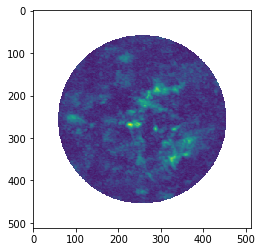

In [27]:
cube = SpectralCube.read('test_nh2d.fits')
cube.max(axis=0).quicklook()

In [29]:
# plt.plot(cube.max(axis=0)) # this is not right but it does look cool
mxspec = cube.max(axis=(1,2))

In [37]:
import pylab as pl
import pyspeckit
kspectrum_ps = pyspeckit.Spectrum(xarr = mxspec.spectral_axis, data = mxspec.value)